In [1]:
import os
import glob
#import nibabel as nib
import numpy as np
import cv2
# import math
import torch
import scipy

import matplotlib.pyplot as plt
import plotly.express as px

import sys
sys.path.append('../')
# print(sys.path)
from src.data.data_generator import MRIDataset
# from src.utils import plot_tumour

In [2]:
data_path = '../data/all/VS-1-30'
scan_path = os.path.join(data_path, 'vs_gk_11')

t1_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t1_*')))
t2_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t2_*')))
seg_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_seg_*')))
print(t1_list)

['../data/all/VS-1-30/vs_gk_1/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_10/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_12/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_13/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_14/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_15/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_16/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_17/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_18/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_19/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_2/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_20/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_21/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_22/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_23/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_24/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_25/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_26

In [3]:
t1_list[2:4]

['../data/all/VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz',
 '../data/all/VS-1-30/vs_gk_12/vs_gk_t1_refT2.nii.gz']

In [4]:
clicks_dataset = MRIDataset(
    t1_list[2:4], t2_list[2:4], seg_list[2:4],
    (40, 256, 256),
    clicks = {
        'use': True,
        'gen_fg': False,
        'gen_bg': False,
        'gen_border': True,
        'num': 3,
        'dst': 10
    }
)

In [5]:
img, label = clicks_dataset[0]
# click_label = click_label[1].unsqueeze(0)

In [6]:
def get_glioma_indices(mask: torch.Tensor) -> tuple[int, int]:
    glioma_indices = torch.nonzero((mask > 0))[:, 1]
    if len(glioma_indices) == 0:
        return 0, 0

    first = glioma_indices[0].item()
    last = glioma_indices[-1].item()

    return first, last

def plot_tumour(mask: torch.Tensor):
    """Plot individual slices of the tumour in one figure."""
    
    # Compute number of slices with the tumour
    first, last = get_glioma_indices(mask)
    print("Tumour indices: ", first, last)

    length = last - first + 1
    n_graphs = (length) // 4
    rows = n_graphs
    cols = 4
    res = cols if cols > rows else rows

    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res * 2, res * 2))
    axs = axs.flatten()
    j = 0
    for i in range(first, last):
        if j >= len(axs):
            break
        axs[j].imshow(mask[0, i, :, :], cmap="magma")
        axs[j].axis("off")
        axs[j].set_title(f"mask slice {i}", fontsize=9)
        j += 1

    plt.show()

Tumour indices:  11 27


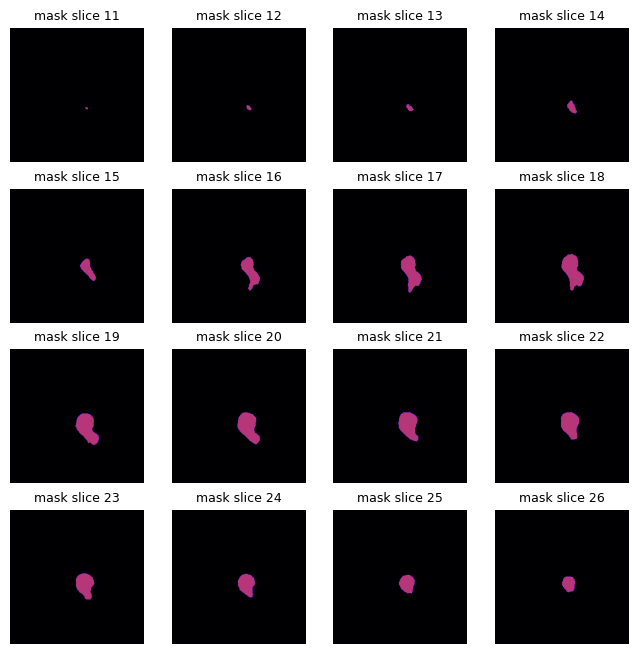

In [7]:
plot_tumour(label[0].unsqueeze(0) + label[1].unsqueeze(0))

### 3d cuts

In [8]:
def _3dcut_volume(volume: torch.Tensor, coords: list[int], cut_size: int, cut_depth: int=8) -> torch.Tensor:
    """ 
    Create a cut from the given volume in shape (cut_size, cut_size).

    Args:
        volume (Tensor): volume to cut
        coords (list of ints): click coordinates
        cut_size (int): size of the generated cut
        cut_depth (int): depth of the cut
    Returns:
        tensor: generated cut in shape (cut_size, cut_size)
    """
    cut = torch.clone(volume)
    cut = cut[:,
        coords[0] - cut_depth : coords[0] + cut_depth,
        coords[1] - cut_size : coords[1] + cut_size,
        coords[2] - cut_size : coords[2] + cut_size,
    ]
    # print(cut.shape, coords)

    return cut

def _cut_volume(volume: torch.Tensor, coords: list[int], cut_size: int) -> torch.Tensor:
    """ 
    Create a cut from the given volume in shape (cut_size, cut_size).

    Args:
        volume (Tensor): volume to cut
        coords (list of ints): click coordinates
        cut_size (int): size of the generated cut
    Returns:
        tensor: generated cut in shape (cut_size, cut_size)
    """

    cut = torch.clone(volume[coords[0]])
    cut = cut[
        coords[1] - cut_size : coords[1] + cut_size,
        coords[2] - cut_size : coords[2] + cut_size,
    ]

    return cut

def _cut_volumes(
    volume: torch.Tensor,
    clicks: torch.Tensor,
    cut_fn=_cut_volume,
    cut_size=32,
    cut_depth=None,
    num: int = np.inf,
    random=False,
) -> list[torch.Tensor]:
    """
    Generate cuts from the given volumes.

    Args:
        seg (Tensor): segmentation mask 
        clicks (Tensor): generated clicks
        cut_size (int): size of the generated cuts
        cut_depth (int): depth of the cut
        num (int): number of cuts to generate
        random (bool): whether to randomize the cuts or create them in order
    Returns:
        list of tensors: list of generated cuts in shape (cut_size, cut_size)
    """

    cut_size = cut_size // 2  # needed only as a distance from the center

    # Get coordinates of the generated points
    click_coords = torch.nonzero(clicks)

    # Randomize cuts
    if random:
        click_coords = click_coords[torch.randperm(len(click_coords))]

    cuts = []
    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]

        # Cut the volume based on the specified cut size
        if cut_depth:
            if coords[0] < cut_depth: 
                continue
            cut = cut_fn(volume, coords, cut_size, cut_depth)
        else:
            cut = cut_fn(volume, coords, cut_size)
        
        cuts.append(cut)

    return cuts

In [27]:
def plot_3dcut(cut: torch.Tensor, plot_click=True, cmap='magma'):
    rows = len(cut)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i, slice in enumerate(cut):
        if j >= len(axs): 
            break
        
        # if len(cut.shape) == 3:
        #     cut = cut.squeeze(0)
        
        tmp_slice = torch.clone(slice)
        if plot_click:
            if i == len(cut)//2:
                tmp_slice[slice.shape[0]//2, slice.shape[0]//2] = 3
            else:
                tmp_slice[slice.shape[0]//2, slice.shape[0]//2] = 2
        
        axs[j].imshow(tmp_slice, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut slice {i}', fontsize=9)
        j += 1

    plt.show()   

def plot_cut(cut, cmap='magma'):
    tmp_cut = torch.clone(cut)
    tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
    plt.imshow(tmp_cut, cmap=cmap)

def plot_3dcuts_with_seq(cut: torch.Tensor, plot_click=True, cmap='magma'):
    rows = cut.shape[1]
    cols = 3
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res//2, res*2))
    axs = axs.flatten()
    j = 0
    
    # print(cut.shape)
    for slice_idx in range(cut.shape[1]):
        if j >= len(axs): 
            break
        
        # if len(cut.shape) == 3:
        #     cut = cut.squeeze(0)
        
        tmp_cut = torch.clone(cut[0,slice_idx])
        if plot_click:
            if slice_idx == cut.shape[1]//2:
                tmp_cut[cut.shape[2]//2, cut.shape[2]//2] = 3
            else:
                tmp_cut[cut.shape[2]//2, cut.shape[2]//2] = 2

        axs[j].imshow(cut[1,slice_idx], cmap='gray')
        axs[j].axis('off')
        axs[j].set_title(f't1 cut {slice_idx}', fontsize=9)
        axs[j+1].imshow(cut[2,slice_idx], cmap='gray')
        axs[j+1].axis('off')
        axs[j+1].set_title(f't2 cut {slice_idx}', fontsize=9)
        axs[j+2].imshow(tmp_cut, cmap=cmap)
        axs[j+2].axis('off')
        axs[j+2].set_title(f'seg cut {slice_idx}', fontsize=9)
        j += 3

    plt.show()   

In [28]:
img, seg = clicks_dataset[0]

In [46]:
cuts = _cut_volumes(torch.stack((seg[0], img[0], img[1])), seg[1], cut_size=40, cut_depth=4, cut_fn=_3dcut_volume)

In [50]:
_cut_volumes(seg[0].unsqueeze(0), seg[1], cut_size=40, cut_depth=4, cut_fn=_3dcut_volume)[0].shape

torch.Size([1, 8, 40, 40])

In [48]:
twod_cuts = _cut_volumes(seg[0], seg[1], cut_fn=_cut_volume)

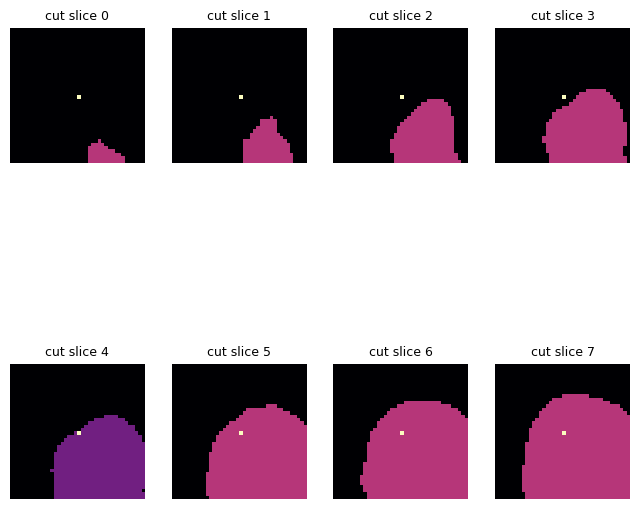

In [49]:
plot_3dcut(cuts[12][0])

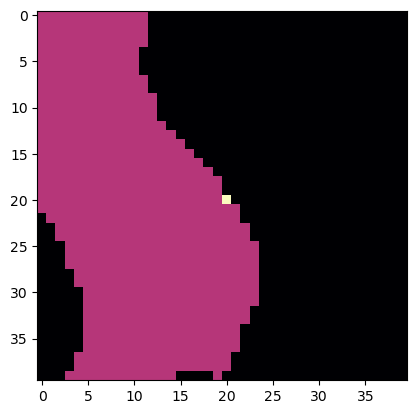

In [17]:
plot_cut(cuts[11][0][cuts[11].shape[1]//2])

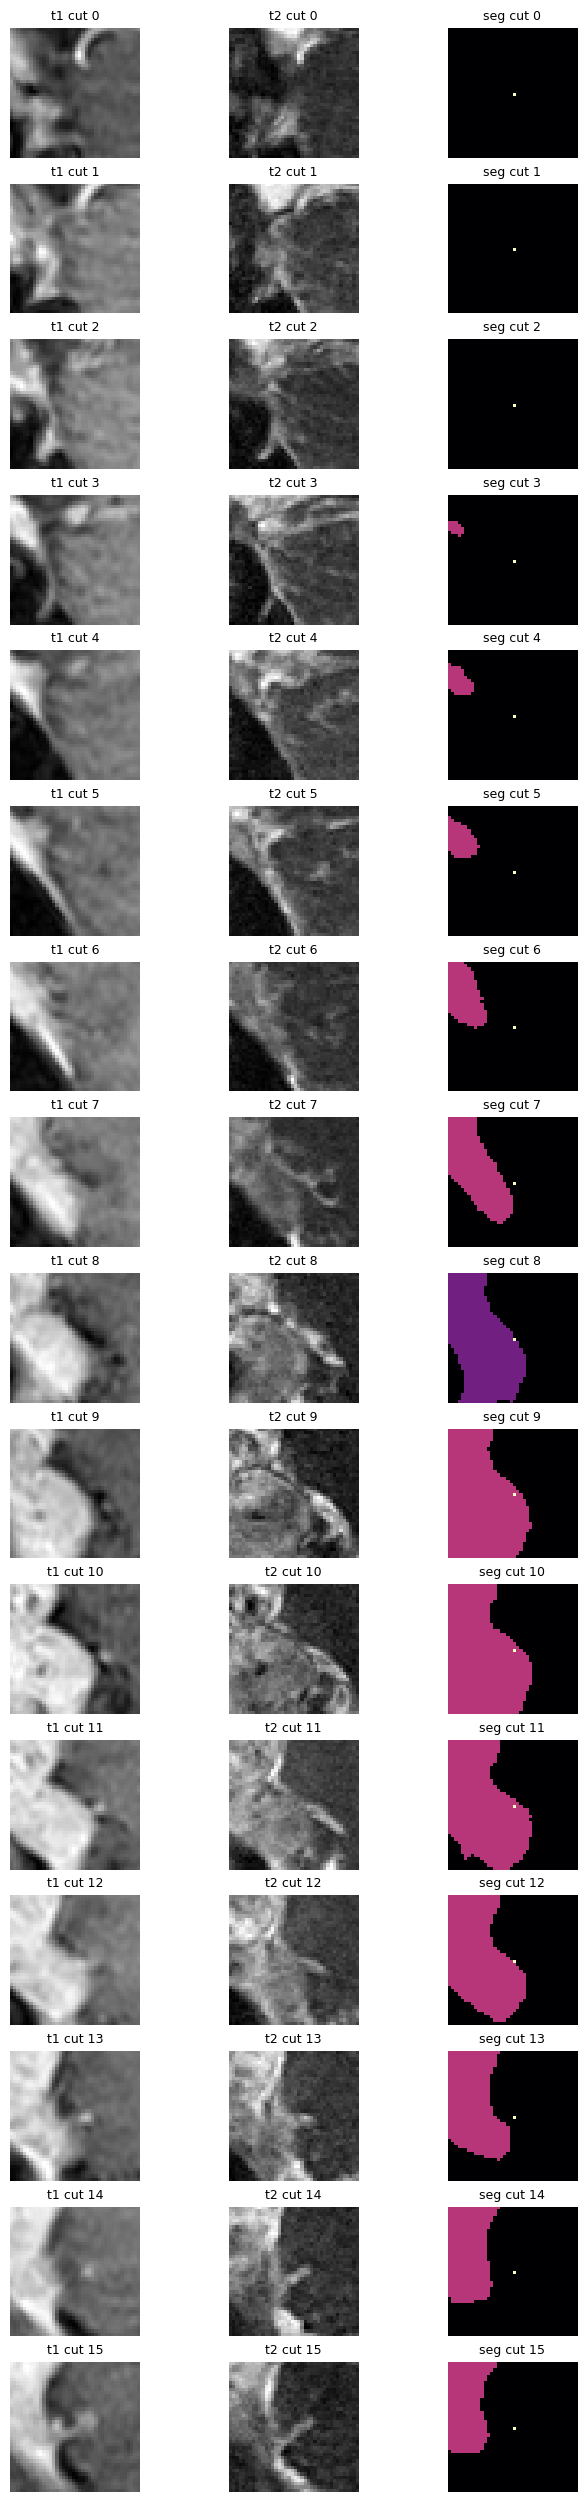

In [15]:
plot_3dcuts_with_seq(cuts[11])

### Simulate errors

In [2]:
12 - 8, 12 + 8

(4, 20)

In [149]:
def _simulate_errors(cuts: list[torch.Tensor], hide_unchanged=False, seed: int | None =None, cuts_with_seq=False) -> list[torch.Tensor]:
    """
    Simulate errors for the generated cuts and return 'erroneous' cuts.
    
    Args:
        cuts (list of tensors): list of generated cuts
        hide_unchanged (bool): whether to leave some cuts unchanged
        seed (int): optional seed, which will be used for rng
        cuts_with_seq (bool): whether the cuts also include sequences
    Returns:
        list of tensors: list of simulated erroneous cuts
    """

    # cuts, _ = cut_volume(label, cut_size=cut_size, num=num)
    erosion_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(5, 5))
    dilatation_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(7, 7))

    faked_cuts = []
    if seed is not None:
        rng = np.random.default_rng(seed=seed)
    else:
        rng = np.random.default_rng()

    # Iterate over generated cuts and either erode or dilate the segmentation
    for cut in cuts:
        pp = rng.uniform(low=0.0, high=1.0)

        # "hide" unchanged cuts
        if hide_unchanged and pp > 0.9:
            faked_cuts.append(cut)
            continue
        
        for slice_idx in range(cut.shape[1]):
            tmp_cut = cut[0,slice_idx]

            # print(tmp_cut.shape)
            
            # use only 1 iterations for smaller tumours
            if len(tmp_cut[tmp_cut > 0]) < 250:
                iterations = 1
            else:
                iterations = 2
            
            if len(tmp_cut[tmp_cut > 0]) < 50:
                # only do dilatation, when the tumour is too small
                tmp_cut = cv2.dilate(tmp_cut.numpy(), kernel=dilatation_kernel, iterations=1)
            else:
                if 0.5 > pp:
                    tmp_cut = cv2.erode(tmp_cut.numpy(), kernel=erosion_kernel, iterations=iterations)
                else:
                    tmp_cut = cv2.dilate(tmp_cut.numpy(), kernel=dilatation_kernel, iterations=iterations)
        
            cut[0,slice_idx] = torch.tensor(tmp_cut)
            faked_cuts.append(cut)

    return faked_cuts

In [145]:
cuts[0].shape

torch.Size([3, 16, 40, 40])

In [150]:
error_cuts = _simulate_errors(cuts)

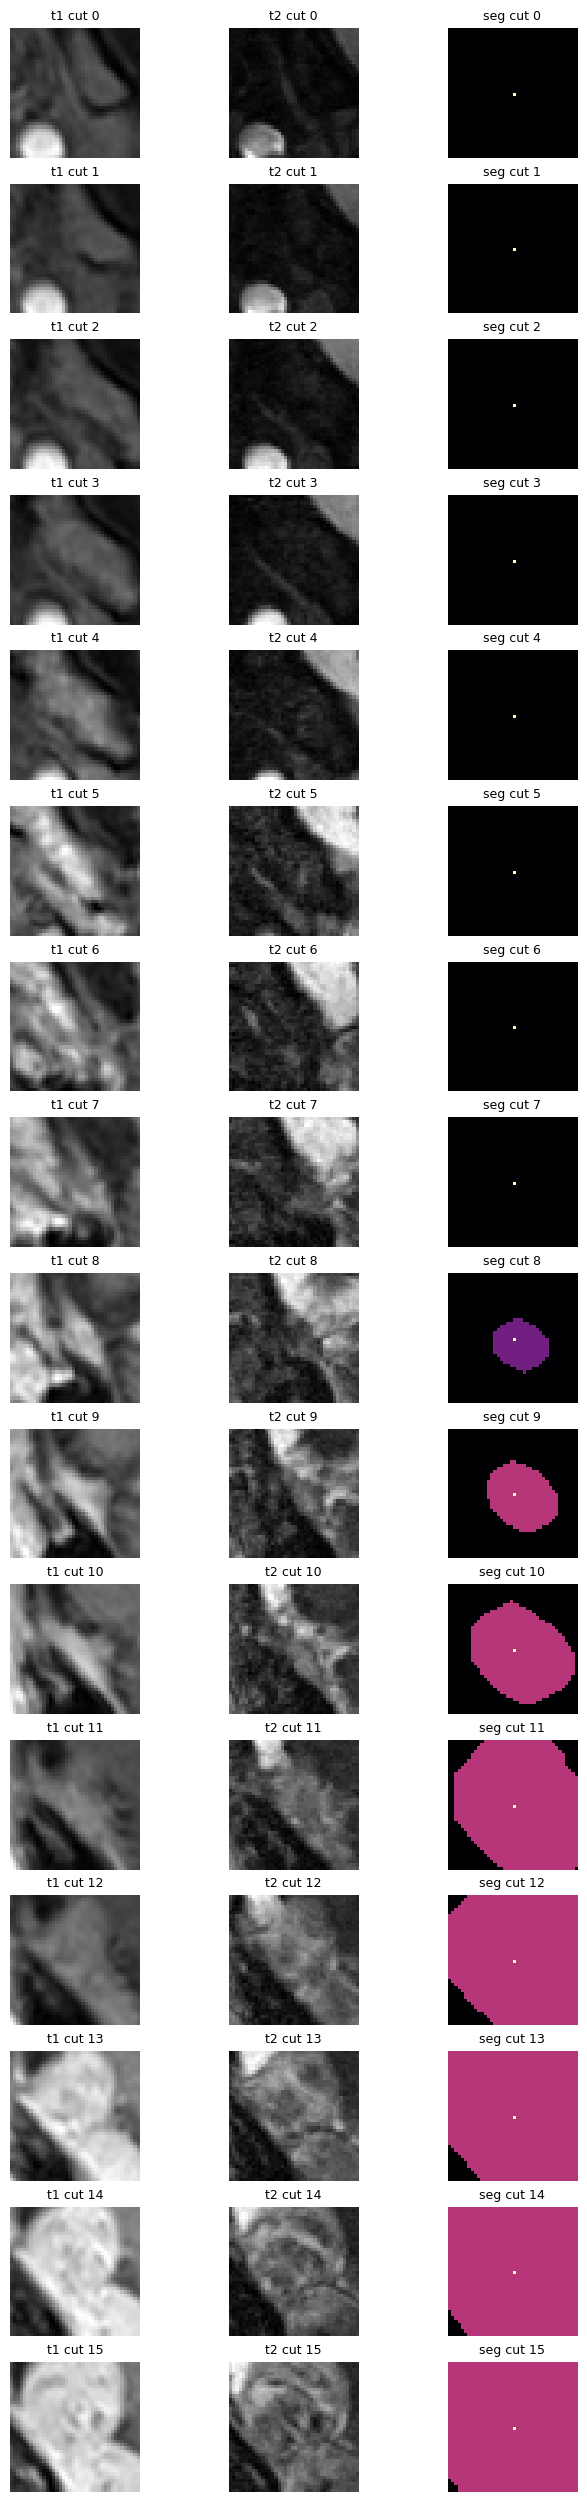

In [151]:
plot_3dcuts_with_seq(error_cuts[0])

In [152]:
import torchvision.transforms.functional as TF

In [153]:
def _augment(cut: torch.Tensor) -> torch.Tensor:
    """ 
    Rotates and flips provided cut.

    Args:
        cut (Tensor): preprocessed cut
    Returns:
        tensor: augmented cut
    """

    rng = np.random.default_rng()
    pp = rng.uniform(low=0.0, high=1.0)

    if pp > 0.8:
        angle = rng.uniform(low=-90, high=90)
        cut = TF.rotate(cut, angle)
    
    if pp > 0.7:
        cut = TF.hflip(cut)
    
    if pp > 0.6:
        cut = TF.vflip(cut)
    
    return cut

In [ ]:
_ = _augment(cuts)